# 加载 CLIP 模型

加载 CLIP 模型，生成图文 Embedding。

- 文本 Embedding：[IDEA-CCNL/Taiyi-CLIP-Roberta-102M-Chinese](https://huggingface.co/IDEA-CCNL/Taiyi-CLIP-Roberta-102M-Chinese)
- 图片 Embedding：[openai/clip-vit-base-patch32](https://huggingface.co/openai/clip-vit-base-patch32)

In [1]:
# !pip install fastapi uvicorn transformers

In [2]:
import base64
import requests
import numpy as np
import pandas as pd
import clip
import torch
import warnings

import utils

from io import BytesIO
from PIL import Image
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from transformers import CLIPProcessor, CLIPModel

warnings.filterwarnings('ignore')

In [3]:
MODEL_PATH = 'model'
IMG_PATH = 'img'

CN_CLIP_PATH = 'Taiyi-CLIP-Roberta-102M-Chinese'
VIT_CLIP_PATH = 'clip-vit-base-patch32'
EMOJI_1_FN = '10.jpg'
EMOJI_2_FN = '11.jpg'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

device: cuda


In [4]:
def init_model(device):
    # 加载 IDEA-CCNL/Taiyi-CLIP-Roberta-102M-Chinese
    clip_model_path = utils.gen_abspath(MODEL_PATH, CN_CLIP_PATH)
    text_tokenizer = BertTokenizer.from_pretrained(clip_model_path)
    text_encoder = BertForSequenceClassification.from_pretrained(clip_model_path).to(device).eval()

    # 加载 openai/clip-vit-base-patch32
    vit_model_path = utils.gen_abspath(MODEL_PATH, VIT_CLIP_PATH)
    clip_model = CLIPModel.from_pretrained(vit_model_path).to(device)
    clip_processor = CLIPProcessor.from_pretrained(vit_model_path)

    return text_tokenizer, text_encoder, clip_model, clip_processor


def to_base64(img_paths):
    """图片转为 base64"""
    images_base64 = [base64.b64encode(open(pth, "rb").read()).decode("utf-8")
                     for pth in img_paths]
    return images_base64


def to_image(images_base64):
    """base64 转为图片"""
    images = [Image.open(BytesIO(base64.b64decode(base64_string)))
              for base64_string in images_base64]
    return images


@torch.inference_mode()
def get_text_embedding(texts, text_tokenizer, text_encoder, device):
    """计算文本 Embedding"""
    inputs = text_tokenizer(texts, return_tensors='pt', padding=True)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    # with torch.no_grad():
    text_features = text_encoder(**inputs).logits

    # 归一化
    text_features = text_features / text_features.norm(dim=1, keepdim=True)

    return text_features


def gen_get_text_embedding(text_tokenizer, text_encoder, device):
    def func(texts,
             text_tokenizer=text_tokenizer,
             text_encoder=text_encoder,
             device=device):
        res = get_text_embedding(texts, text_tokenizer, text_encoder, device)
        return res
    return func


@torch.inference_mode()
def get_image_embedding(images, clip_model, clip_processor, device):
    """计算图像 Embedding"""
    inputs = clip_processor(images=images, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}
    # with torch.no_grad():
    image_features = clip_model.get_image_features(**inputs)

    # 归一化
    image_features = image_features / image_features.norm(dim=1, keepdim=True)

    return image_features


def gen_get_image_embedding(clip_model, clip_processor, device):
    def func(images,
             clip_model=clip_model,
             clip_processor=clip_processor,
             device=device):
        res = get_image_embedding(images, clip_model, clip_processor, device)
        return res
    return func


def get_url_raw(url):
    """获取图像 url 内容"""
    return requests.get(url, stream=True).raw


@torch.inference_mode()
def compute_similarity(feature, features):
    """计算图文嵌入余弦相似度"""
    # with torch.no_grad():
    logit_scale = clip_model.logit_scale.exp()  # logit_scale 是尺度系数
    logits_per_image = logit_scale * feature @ features.t()
    logits_per_text = logits_per_image.t()
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    return np.around(probs, 3)


text_tokenizer, text_encoder, clip_model, clip_processor = init_model(device)

calc_text_embedding = gen_get_text_embedding(text_tokenizer, text_encoder, device)
calc_image_embedding = gen_get_image_embedding(clip_model, clip_processor, device)

## 1. 获取文本 Embedding

In [5]:
# 获取文本 Embedding
texts = ['一只猫', '一只狗', '两只猫', '两只狗', '一只老虎', '两只老虎']
text_features = calc_text_embedding(texts)
print(text_features.shape)

torch.Size([6, 512])


## 2. 获取图像 Embedding

torch.Size([1, 512])


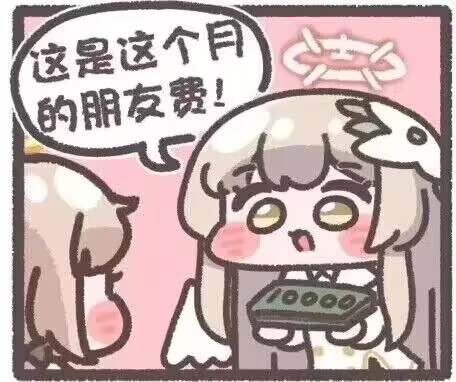

In [6]:
# 获取图像 Embedding
img_path = utils.gen_abspath(IMG_PATH, EMOJI_1_FN)
images = [Image.open(img_path)]
image_features = calc_image_embedding(images)
print(image_features.shape)

images[0]

## 3. 多条文本对一张图片

In [7]:
# 多条文本对一张图片，计算图文相似度
probs = compute_similarity(image_features, text_features)
df = pd.DataFrame({
    'query': texts,
    'probs': probs[0].tolist()
})
df

,query,probs
0,一只猫,0.010
1,一只狗,0.011
2,两只猫,0.686
3,两只狗,0.169
4,一只老虎,0.008
5,两只老虎,0.116


## 4. 一条文本对多张图片 

In [8]:
# 一条文本对多张图片
text = '一只猫'
text_features = calc_text_embedding(text)

images = [Image.open(utils.gen_abspath(IMG_PATH, EMOJI_1_FN)),
          Image.open(utils.gen_abspath(IMG_PATH, EMOJI_2_FN))]
image_features = calc_image_embedding(images)

probs = compute_similarity(text_features, image_features)
probs

array([[0., 1.]], dtype=float32)

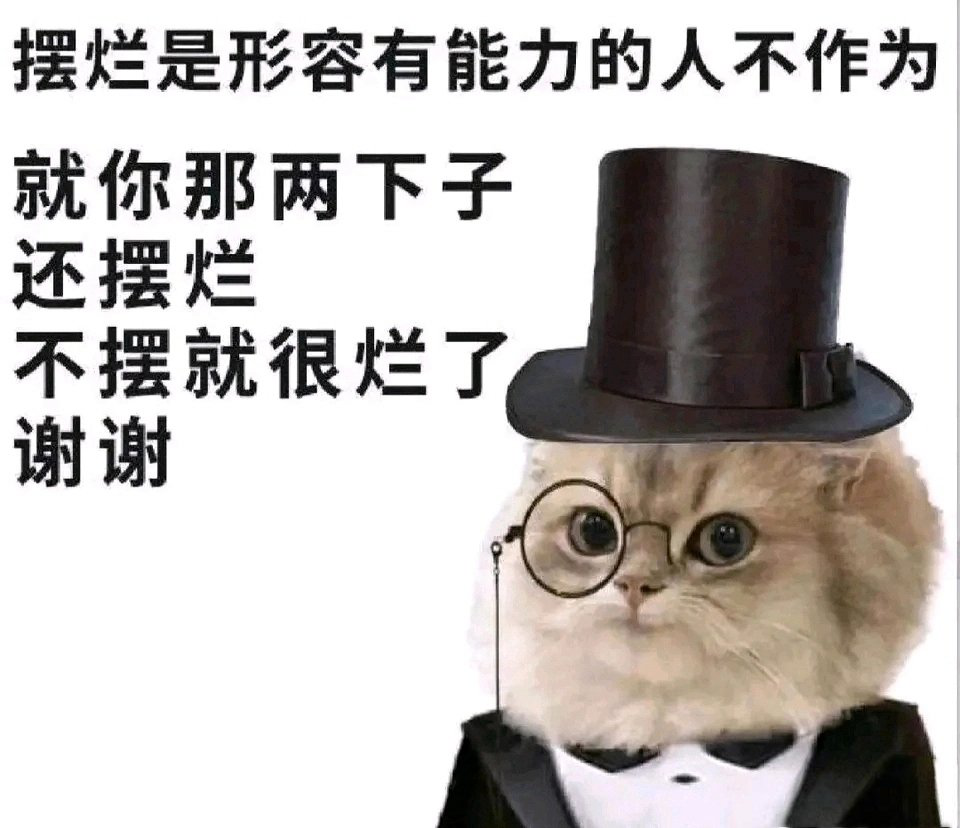

In [9]:
images[np.argmax(probs)]

## 5. 多条文本对多张图片

In [10]:
# 多条文本对多张图片
texts = ['一只猫', '动漫小人']
text_features = calc_text_embedding(texts)

images = [Image.open(utils.gen_abspath(IMG_PATH, EMOJI_1_FN)),
          Image.open(utils.gen_abspath(IMG_PATH, EMOJI_2_FN))]
image_features = calc_image_embedding(images)

probs = compute_similarity(text_features, image_features)
probs

array([[0.   , 1.   ],
       [0.692, 0.308]], dtype=float32)